In [78]:
%matplotlib inline
########## DISABLE GPU
import os
import sys

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda/lib64"
sys.path.append("../vsegmenter")

import numpy as np
import tensorflow as tf
from eval.run_eval import load_model
from data.dataset import Dataset
from vsegmenter import cfg
from matplotlib import pyplot as plt

cfg.configLog()

import logging

In [2]:
def plot_images(sample, ax = None):
    if ax is None:
        fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10,20))
    
    ax[0].matshow(sample["image"]); ax[0].set_title(sample["filename"]); ax[0].axis('off')
    ax[1].matshow((sample["mask"]*255).astype(np.uint8), cmap="gray", vmin=0, vmax=255)
    ax[1].set_title(f"Extraction {sample['extraction']}"); ax[1].axis('off')
    ax[2].matshow((sample["prediction"]*255), cmap="gray", vmin=0, vmax=255) 
    ax[2].set_title(f"Predicted Mask {sample['count']}"); ax[2].axis('off')
    
    
    

In [3]:
version = "v5"
model_label = "unet"
img_size = 128

dataset_file = cfg.dataset(f'{version}/dataset_{img_size}.pickle')
x_train, y_train, x_val, y_val = Dataset.load_from_file(dataset_file)

# x_val = x_val[:20]
# y_val = y_val[:20]
x_val = x_train
y_val = y_train

print(f"Num samples: {len(y_val)}")


2023-04-20 07:26:26 INFO Number of train samples: 1508, test samples = 377
2023-04-20 07:26:26 INFO Sample dimensions: sample: (128, 128, 3) label (mask): (128, 128, 2)
2023-04-20 07:26:26 INFO Original image shape : (1508, 128, 128, 3)


Num samples: 1508


In [4]:
validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

model = load_model(cfg.results("unet_v4.model"))

logging.info("Running prediction model.")
y_pred = model.predict(x_val)

logging.info("Prediction sucessfully executed")

2023-04-20 07:26:26.643607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 07:26:26.712283: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 07:26:26.714007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 07:26:26.716017: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
pred_mask = tf.math.argmax(y_pred, axis=-1)
pred_mask = pred_mask[..., np.newaxis]
#pred_mask = y_pred[...,1, np.newaxis]

# detect the problems, get the top-20 images with errors
bg_diff = np.abs( y_pred[:, ..., 1] - y_val[:, ..., 1])
sum_bg_diff_item_wise = np.sum(bg_diff, axis=(1, 2))
ordered = np.argsort(-sum_bg_diff_item_wise)

logging.info(f"Worst samples prepared {sum_bg_diff_item_wise[ordered]}")
logging.info(f"Indexes {ordered}")

2023-04-20 07:26:51 INFO Worst samples prepared [1.6176703e+04 1.6171369e+04 1.6165516e+04 ... 1.2765106e+00 9.0092385e-01
 2.2109438e-01]
2023-04-20 07:26:51 INFO Indexes [ 515 1090  274 ...  108  543 1123]


In [19]:
top_ordered = ordered[:100]
# get original image files
dts = Dataset(os.path.dirname(dataset_file))
lst = dts.get_samples_info_by_idx(top_ordered, test=False)
for i, index in enumerate(top_ordered):
    lst[i]["index"] = index
    lst[i]["prediction"] = pred_mask[index][..., 0]
    lst[i]["count"] = {sum_bg_diff_item_wise[index]}



2023-04-20 07:31:33 INFO Appending extraction info to samples


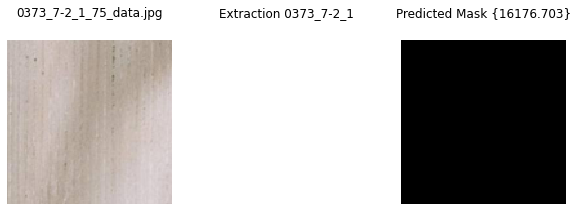

In [7]:
sample_indx = 0
sample1 = lst[sample_indx]
idx = top_ordered[sample_indx]
bg_diff = np.abs(y_val[idx,..., 1]- y_pred[idx, ..., 1])

plot_images(sample1)


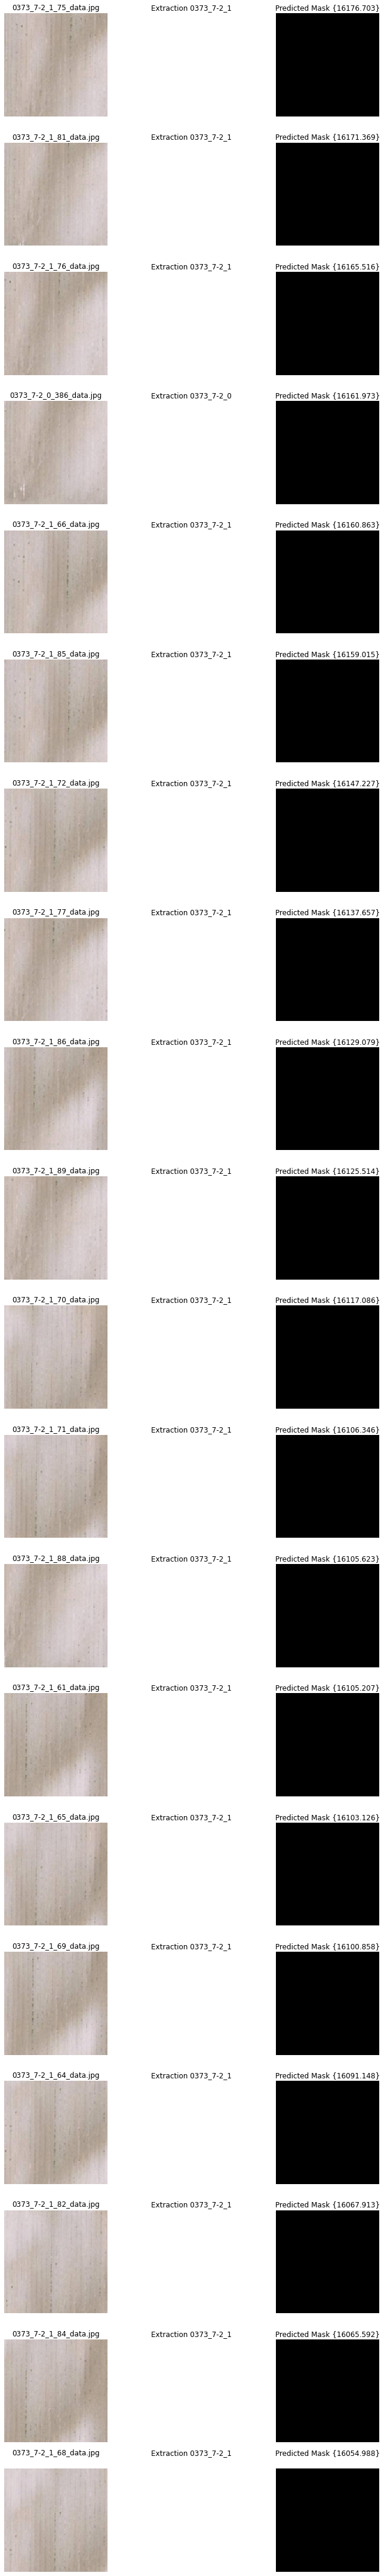

In [8]:
num_images = len(lst)
# crear la figura para mostrar las imágenes
fig, ax = plt.subplots(num_images, 3, sharex=True, sharey=True, figsize=(10,int(num_images*3)))

# iterar sobre las imágenes seleccionadas y mostrar las imágenes y las máscaras originales y predichas
for i in range(num_images):
    sample = lst[i]
    plot_images(sample, ax[i])
# ajustar el diseño de las imágenes en la figura
plt.tight_layout()

In [20]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.cluster import KMeans
from skimage.transform import resize
from tensorflow.python.keras import backend as K


new_size = (224,224)
worst_images = x_val[top_ordered,...]
resized_images = np.zeros((worst_images.shape[0], *new_size, 3))
for i in range(worst_images.shape[0]):
    resized_images[i] = resize(worst_images[i], new_size)


K.clear_session()
tf.keras.backend.clear_session()

    
# Extraer las características de las imágenes
model = ResNet50(weights='imagenet', include_top=True)
logging.info(f"Extracting image features {len(worst_images)}")
features = model.predict(resized_images)
logging.info(f"Finished {features.shape}")


2023-04-20 07:31:42 INFO Extracting image features 100


2023-04-20 07:31:42 WARNING 6 out of the last 53 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fe520932ee0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2023-04-20 07:31:43 INFO Finished (100, 1000)


In [84]:
# Aplicar clustering K-means
kmeans = KMeans(n_clusters=5, random_state=0).fit(features)

# Obtener las etiquetas de clustering
labels = kmeans.labels_

# Imprimir las etiquetas de cada imagen
clusters = {}
image_labels = []
for i, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(i)
    image_labels.append(label)


In [92]:
def plot_cluster(images, max_images=30):
    num_images = min(len(images),max_images)
    # crear la figura para mostrar las imágenes
    fig, ax = plt.subplots(num_images, 3, sharex=True, sharey=True, figsize=(10,int(num_images*3)))    
    for i,image_idx in enumerate(images[:num_images]):
        # get original image:
        sample = lst[image_idx]
        plot_images(sample, ax[i])

def plot_image_by_id(id):
        sample = lst[id]
        plot_images(sample)
            

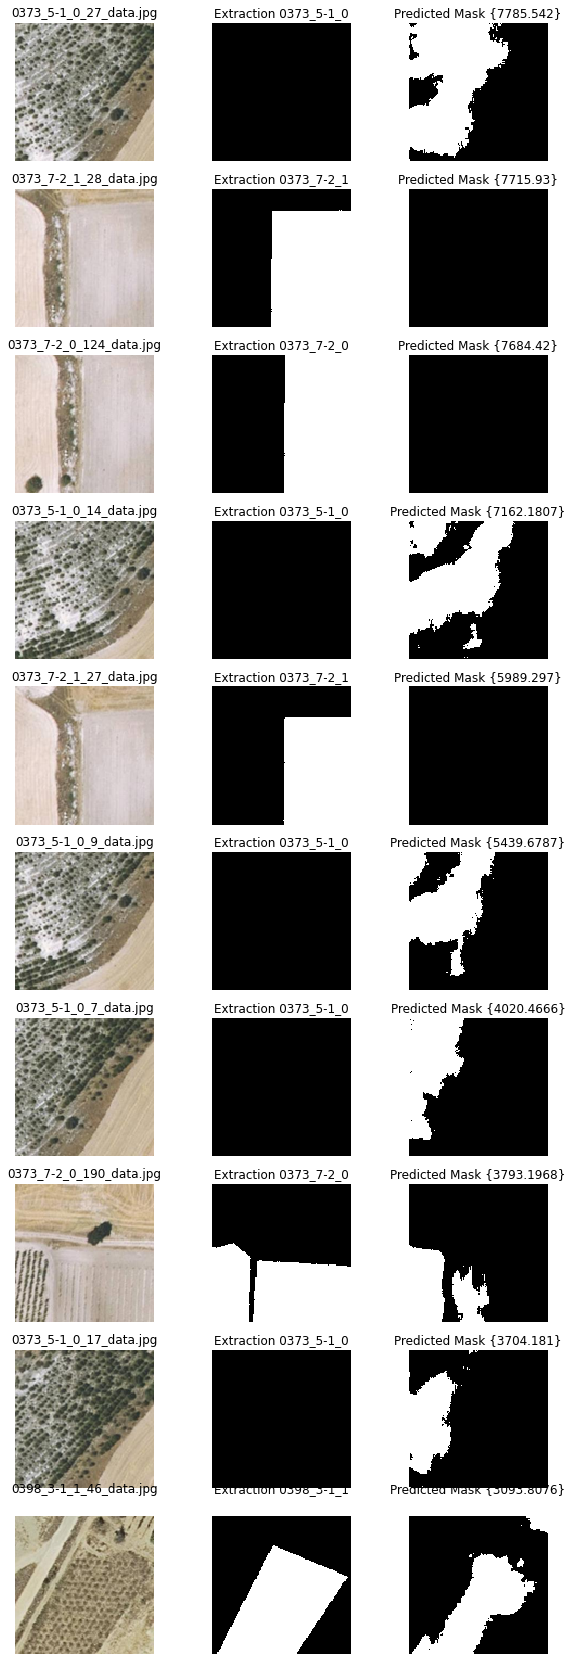

In [42]:
plot_cluster(clusters[0], max_images=10)

In [ ]:
plot_cluster(clusters[1], max_images=10)

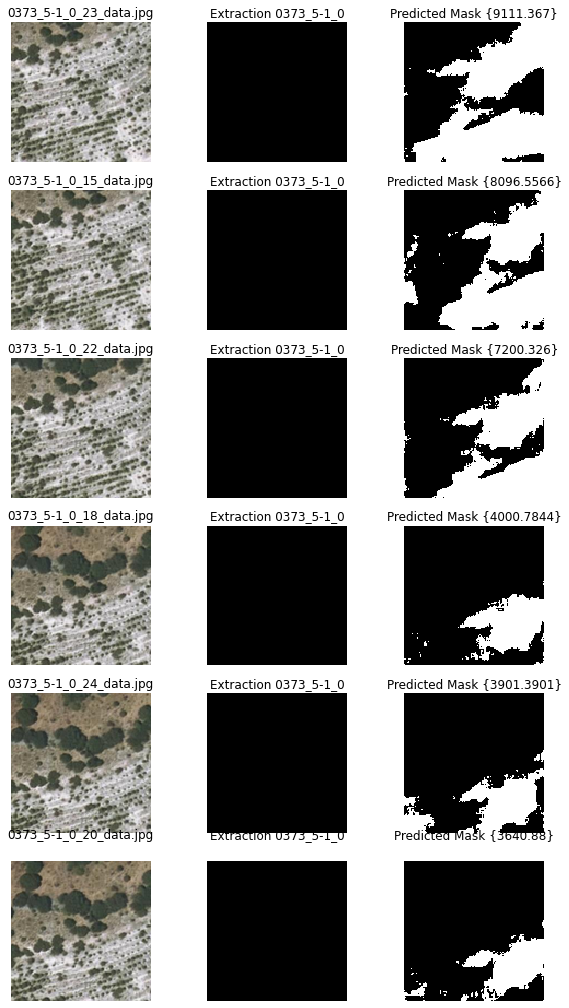

In [44]:
plot_cluster(clusters[2], max_images=20)

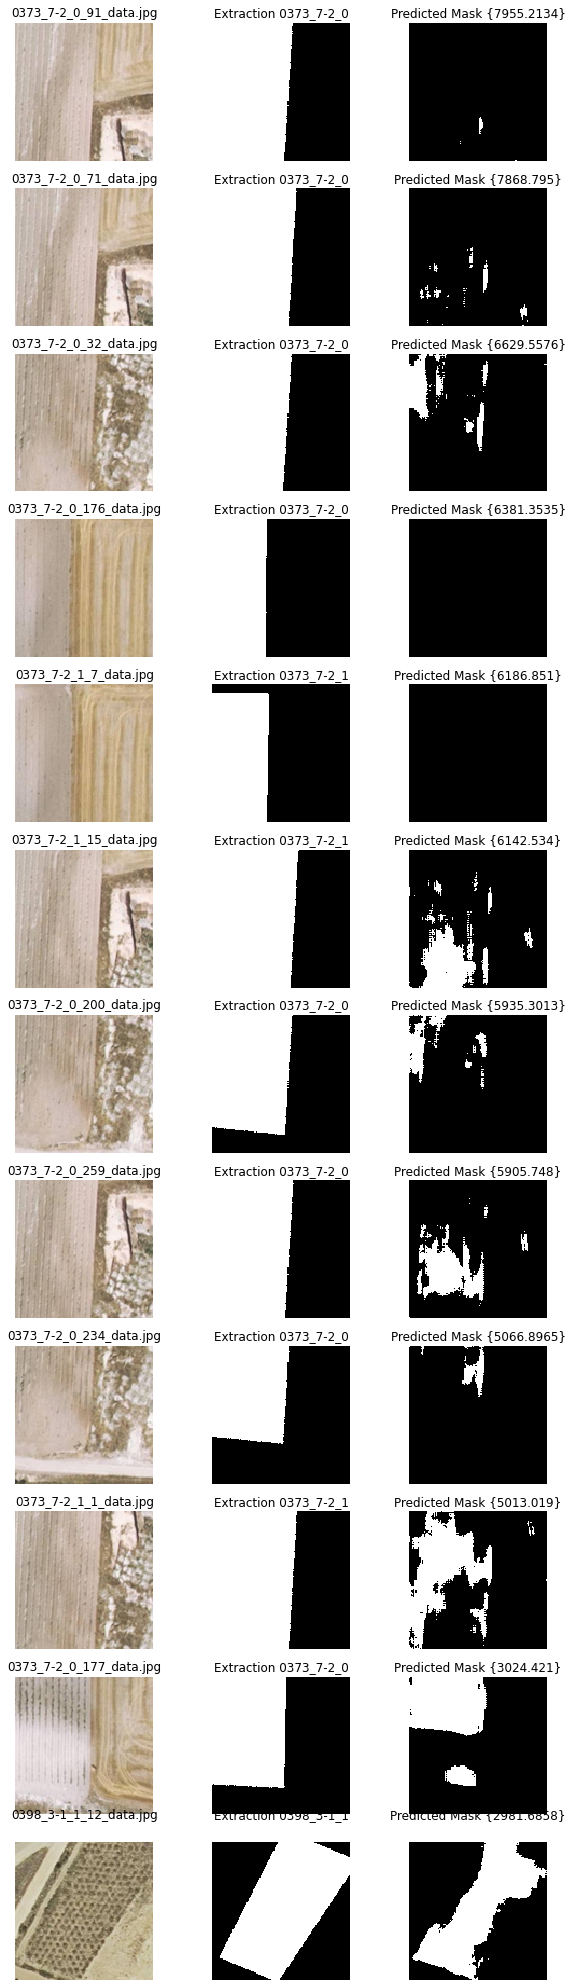

In [45]:
plot_cluster(clusters[3], max_images=20)

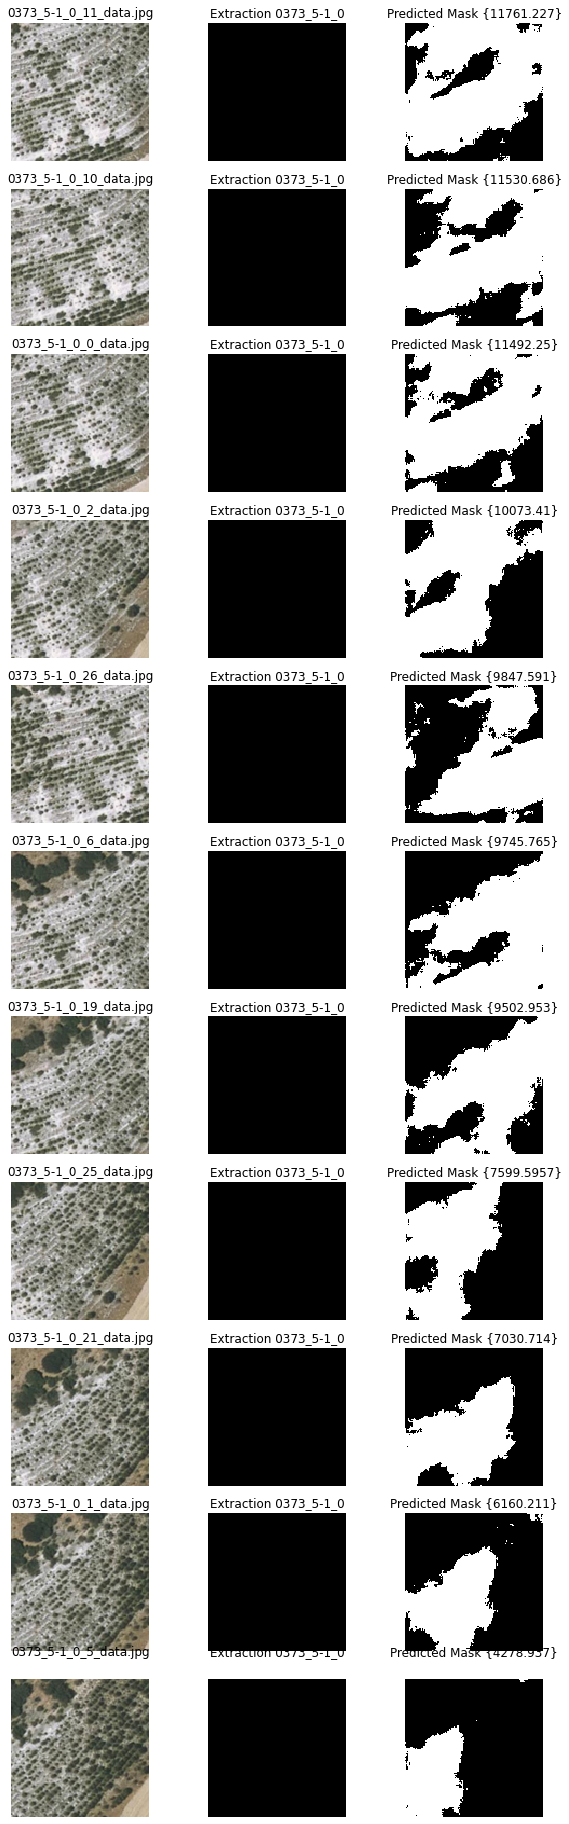

In [46]:
plot_cluster(clusters[4], max_images=20)

In [49]:
# Calculate optimal number of clusters
sse = []
for num_clusters in range(1, 25):
    model = KMeans(n_clusters=num_clusters, random_state=0).fit(features)
    sse.append(model.inertia_)

In [51]:
sse

[0.00361744430847466,
 0.0014365310780704021,
 0.0010474619921296835,
 0.0007515060715377331,
 0.0006201001815497875,
 0.0004970695008523762,
 0.00039601794560439885,
 0.0003507350629661232,
 0.00032183833536691964,
 0.0002900941180996597,
 0.00026594073278829455,
 0.0002546022005844861,
 0.00022751859796699136,
 0.00020988634787499905,
 0.00019718101248145103,
 0.00018961590831167996,
 0.00017461164679843932,
 0.0001627995225135237,
 0.0001539183285785839,
 0.00013767348718829453,
 0.00013310083886608481,
 0.0001255747047252953,
 0.0001234521478181705,
 0.0001138470324804075]

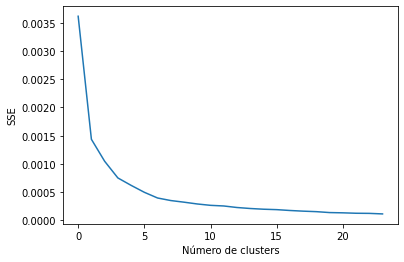

In [59]:
plt.plot(range(len(sse)), sse)
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.show()

In [82]:
image_labels

[]

/media/gus/workspace/wpy/venvs/basictf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/media/gus/workspace/wpy/venvs/basictf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


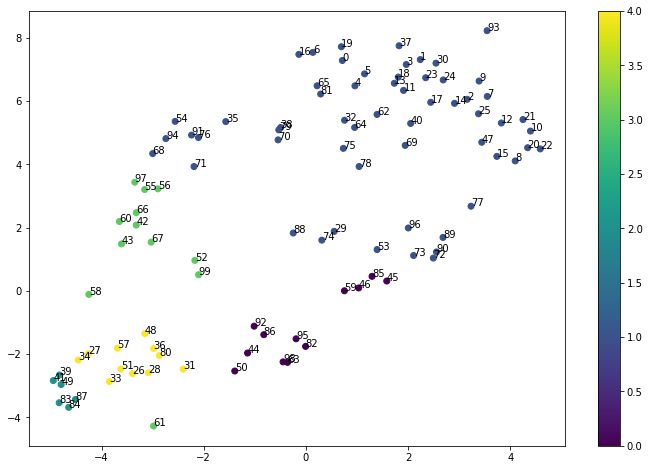

In [90]:
from sklearn.manifold import TSNE

# Project features using tSNE
# Aplicar t-SNE
tsne = TSNE(n_components=2)
projected_features = tsne.fit_transform(features.reshape(features.shape[0], -1))

# Graficar los puntos proyectados
# plt.scatter(projected_features[:, 0], projected_features[:, 1])
# plt.show()


# Crea la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 8))

# Grafica los puntos en la proyección TSNE y agrega una etiqueta para cada punto
scatter = ax.scatter(projected_features[:,0], projected_features[:,1], c=image_labels)

# Recorre todos los puntos y agrega el ID de la imagen en su ubicación
for i, txt in enumerate(range(len(image_labels))):
    ax.annotate(txt, (projected_features[i,0], projected_features[i,1]))

for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        text = ax.text(j, i, image[i, j], ha="center", va="center", color="w")
 

# Agrega una barra de color para mostrar los índices correspondientes a los puntos
colorbar = plt.colorbar(scatter)

# Define la función que muestra la imagen correspondiente cuando haces clic en un punto
def on_click(event):
#     if event.inaxes == ax:
    index = int(event.ind[0])
#         image = images[index] 
    image = lst[index]
    print("asdfasfas")
    plt.figure()
    plt.imshow(image)
    plt.show()

# Agrega la función de clic a la figura
fig.canvas.mpl_connect('button_press_event', on_click)

# Muestra la figura
plt.show()


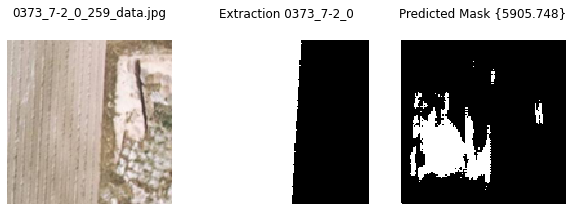

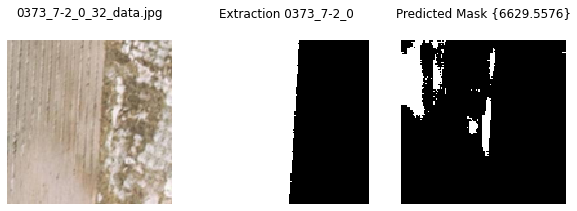

In [99]:

plot_image_by_id(61)
plot_image_by_id(52)
